In [80]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['bar', 'datetime', 'fill']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
import os

In [6]:
import sys
sys.path.append('../')
import timing
from pathlib import Path

In [7]:
import xarray as xr
import numpy as np
import pandas as pd

In [72]:
import netCDF4

In [8]:
from tqdm import tqdm

In [9]:
from datetime import datetime, timedelta

In [10]:
from importlib import reload

In [11]:
from utils import ALL_SATS, remap_fast_mean

In [12]:
import os

In [13]:
from make_index import get_index_bands

In [14]:
from make_sample import open_index, band_dir_path, read_scene

In [15]:
import satpy

In [16]:
sys.path.append('/ships19/cloud/scratch/cphillips/utility/')
import make_gif

In [17]:
VIDEOS = Path('videos')

In [18]:
os.environ['XRIT_DECOMPRESS_PATH'] = str(Path('../xrit/PublicDecompWT/xRITDecompress/xRITDecompress').absolute())

In [19]:
COMP_CACHE = Path('../composite_cache/')
INDEX = Path('../index')
L1B_DIR = Path('../l1b')
ABI_SCAN_DIR = Path('../ancil/abi_scan_schedule/')

In [64]:
dt = pd.to_datetime('2020-01-02T00:30')

wmo_ids = xr.open_dataset(COMP_CACHE / 'wmo_id.nc').wmo_id
sample_mode = xr.open_dataset(COMP_CACHE / 'sample_mode.nc').sample_mode

grid_shape = wmo_ids.shape

In [65]:
%%time
composite = xr.DataArray(np.full(grid_shape, np.nan, dtype=np.float32), dims=['layer','latitude','longitude'])

for attrs in ALL_SATS[:]:
    print(attrs['name'])
    _,index_band = max(get_index_bands(attrs['res']).items())

    src_index, dst_index, src_index_nn, dst_index_nn = open_index(INDEX, attrs['sat'], index_band)

    band_dir = band_dir_path(L1B_DIR, dt, attrs['sat'], 'temp_11_00um')

    files = list(band_dir.glob('*'))
    v, area = read_scene(files, attrs['reader'])

    reload(timing)

    if attrs['reader'] == 'seviri_l1b_hrit':
        start_time, line_times = timing.meteosat_get_time_offset(v)
        offsets = timing.meteosat_estimate_pixel_time_offsets(line_times)

    elif attrs['reader'] == 'ahi_hsd':
        start_time, line_times = timing.himawari_line_times(files)
        offsets = timing.himawari_estimate_pixel_time_offsets(line_times)

    elif attrs['reader'] == 'abi_l1b':
        offsets = timing.goes_pixel_time_offset(ABI_SCAN_DIR)
        start_time = timing.goes_start_time(files)
    adjust = (start_time - dt).total_seconds()
    offsets += adjust

    print('remap')
    out_nn = remap_fast_mean(src_index_nn, dst_index_nn, offsets, grid_shape[-2:])

    print('composite')
    for layer in range(composite.shape[0]):
        mask = (wmo_ids[layer].values  == attrs['wmo_id'])
        composite.values[layer, mask] = out_nn[mask]

GOES-16
remap
composite
GOES-17
remap
composite
Himawari-8
remap
composite
Meteosat-8
remap
composite
Meteosat-11
remap
composite
CPU times: user 6.05 s, sys: 2.16 s, total: 8.21 s
Wall time: 17.8 s


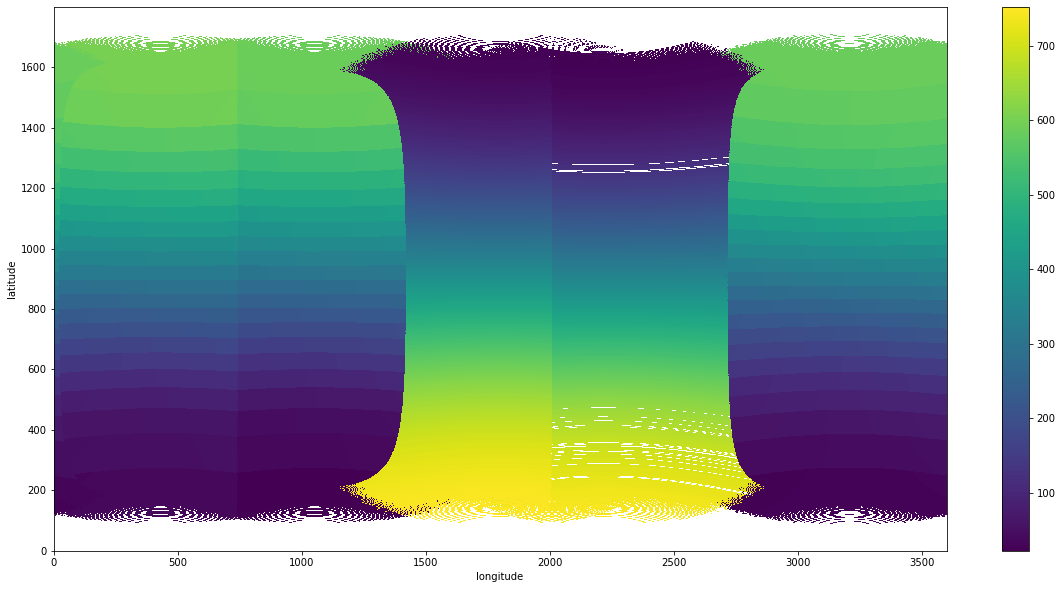

In [66]:
composite[0].plot.imshow(figsize=(20,10))

In [58]:
end_s = composite.max()+10
start_s = min(composite.min().item(), 0)

In [27]:
import PIL.Image

In [28]:
cache = COMP_CACHE / dt.strftime('%Y') / dt.strftime('%Y%m') / dt.strftime('%Y%m%d') / dt.strftime('%Y%m%dT%H%M') / 'temp_11_00um.nc'

In [29]:
bt11 = xr.open_dataset(cache).temp_11_00um.values

In [30]:
last_t = 0
canvas = np.zeros((*grid_shape[-2:],3), dtype=np.uint8)
video = VIDEOS / 'test_timing.mp4'
with make_gif.make_video(video, framerate=30) as vid:
    with tqdm(np.arange(start_s, end_s, 3.33)) as bar:
        for t in bar:
            mask = (composite.values >= last_t) & (composite.values< t)
            mask_any = mask.any(axis=0)
            canvas[mask_any,0] = 255
            canvas[mask_any,1] = 0
            canvas[mask_any,2] = 0
            last_t = t
            im = PIL.Image.fromarray(canvas).resize((1024, 512))
            im.save(vid,format='png')
            idx = np.argmax(mask, axis=0)[np.newaxis]
            bt = np.nan_to_num(np.take_along_axis(bt11, idx, axis=0)[0,mask_any], nan=320)
            bt = 255-((bt-160)/(320-160)*255).clip(0,255).astype(np.uint8)
            canvas[mask_any,0] = bt
            canvas[mask_any,1] = bt
            canvas[mask_any,2] = bt

100%|██████████| 229/229 [01:33<00:00,  2.45it/s]


ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/data/cphillips/miniconda3/envs/ffmpeg --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'vide

In [94]:
make_gif.play_video(video)

# Do for real

In [76]:
def saveit(composite, out):
    fill = netCDF4.default_fillvals['i2']
    ds = xr.Dataset()
    ds['pixel_time'] = composite.fillna(fill).astype(np.int16)

    encoding = {'pixel_time':{'zlib':True,'chunksizes':(1, 1800, 3600), '_FillValue':fill, 'dtype':'i2'}}

    ds.to_netcdf(out, encoding=encoding)

In [70]:
dts = [datetime.strptime(i.name,'%Y%m%dT%H%M') for i in COMP_CACHE.glob('*/*/*/*')]

In [79]:
errors = []
with tqdm(dts) as bar:
    for dt in bar:
        
        out_dir = COMP_CACHE / dt.strftime('%Y') / dt.strftime('%Y%m') / dt.strftime('%Y%m%d') / dt.strftime('%Y%m%dT%H%M')
        out_path = out_dir / 'pixel_time.nc'
        if out_path.exists():
            continue

        composite = xr.DataArray(np.full(grid_shape, np.nan, dtype=np.float32), dims=['layer','latitude','longitude'])

        try:
            for attrs in ALL_SATS[:]:
                prefix = (attrs['name'])
                _,index_band = max(get_index_bands(attrs['res']).items())

                src_index, dst_index, src_index_nn, dst_index_nn = open_index(INDEX, attrs['sat'], index_band)

                band_dir = band_dir_path(L1B_DIR, dt, attrs['sat'], 'temp_11_00um')

                files = list(band_dir.glob('*'))
                v, area = read_scene(files, attrs['reader'])

                reload(timing)

                if attrs['reader'] == 'seviri_l1b_hrit':
                    start_time, line_times = timing.meteosat_get_time_offset(v)
                    offsets = timing.meteosat_estimate_pixel_time_offsets(line_times)

                elif attrs['reader'] == 'ahi_hsd':
                    start_time, line_times = timing.himawari_line_times(files)
                    offsets = timing.himawari_estimate_pixel_time_offsets(line_times)

                elif attrs['reader'] == 'abi_l1b':
                    offsets = timing.goes_pixel_time_offset(ABI_SCAN_DIR)
                    start_time = timing.goes_start_time(files)
                adjust = (start_time - dt).total_seconds()
                offsets += adjust

                bar.set_description(f'{prefix}: remap')
                out_nn = remap_fast_mean(src_index_nn, dst_index_nn, offsets, grid_shape[-2:])

                bar.set_description(f'{prefix}: composite')
                for layer in range(composite.shape[0]):
                    mask = (wmo_ids[layer].values  == attrs['wmo_id'])
                    composite.values[layer, mask] = out_nn[mask]
            saveit(composite, out_path)
            bar.set_description(f'Saved {out_path}')
        except OSError:
            errors.append(dt)

Meteosat-8: composite:   0%|          | 0/1827 [00:07<?, ?it/s]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:   1%|          | 22/1827 [03:17<7:32:50, 15.05s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:   2%|▏         | 42/1827 [08:30<7:46:51, 15.69s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:   3%|▎         | 59/1827 [12:55<7:48:48, 15.91s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:   3%|▎         | 63/1827 [13:57<7:31:22, 15.35s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:   6%|▌         | 102/1827 [24:14<7:37:37, 15.92s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:   8%|▊         | 142/1827 [34:32<7:27:41, 15.94s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  11%|█         | 199/1827 [50:12<7:24:30, 16.38s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  13%|█▎        | 229/1827 [58:19<7:43:11, 17.39s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  13%|█▎        | 243/1827 [1:01:50<6:56:05, 15.76s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  15%|█▌        | 275/1827 [1:10:09<6:59:27, 16.22s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  23%|██▎       | 412/1827 [1:41:59<6:41:07, 17.01s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  24%|██▎       | 430/1827 [1:46:05<4:27:58, 11.51s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  28%|██▊       | 509/1827 [2:06:47<5:57:15, 16.26s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  29%|██▉       | 527/1827 [2:12:06<6:33:46, 18.17s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  29%|██▉       | 529/1827 [2:12:38<6:08:17, 17.02s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  29%|██▉       | 532/1827 [2:13:31<6:17:59, 17.51s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  32%|███▏      | 586/1827 [2:28:26<5:44:04, 16.64s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  35%|███▌      | 646/1827 [2:45:06<5:21:51, 16.35s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  36%|███▌      | 662/1827 [2:49:22<5:26:02, 16.79s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  36%|███▋      | 663/1827 [2:49:37<4:47:33, 14.82s/it]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  40%|████      | 732/1827 [3:04:25<3:39:25, 12.02s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  45%|████▍     | 815/1827 [3:19:26<3:37:16, 12.88s/it]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  53%|█████▎    | 975/1827 [3:58:27<3:54:07, 16.49s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  54%|█████▎    | 979/1827 [3:59:28<3:35:40, 15.26s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  54%|█████▎    | 982/1827 [4:00:13<3:33:27, 15.16s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  55%|█████▍    | 999/1827 [4:05:04<3:58:52, 17.31s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  59%|█████▊    | 1070/1827 [4:20:47<3:31:21, 16.75s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  60%|█████▉    | 1091/1827 [4:25:48<2:56:55, 14.42s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  62%|██████▏   | 1135/1827 [4:34:34<1:55:53, 10.05s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  64%|██████▍   | 1165/1827 [4:40:14<2:04:02, 11.24s/it]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  68%|██████▊   | 1246/1827 [4:59:52<2:39:59, 16.52s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  68%|██████▊   | 1250/1827 [5:00:52<2:40:42, 16.71s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  69%|██████▉   | 1257/1827 [5:02:50<2:41:21, 16.99s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  71%|███████   | 1299/1827 [5:14:31<2:21:48, 16.11s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  73%|███████▎  | 1331/1827 [5:23:29<2:17:56, 16.69s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  73%|███████▎  | 1332/1827 [5:23:43<2:12:37, 16.08s/it]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  73%|███████▎  | 1341/1827 [5:26:09<2:13:16, 16.45s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  74%|███████▍  | 1356/1827 [5:30:19<2:14:01, 17.07s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  76%|███████▌  | 1382/1827 [5:37:42<2:12:37, 17.88s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  77%|███████▋  | 1415/1827 [5:47:06<2:11:31, 19.15s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  78%|███████▊  | 1417/1827 [5:47:34<2:05:37, 18.39s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  81%|████████▏ | 1489/1827 [6:03:20<1:04:26, 11.44s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  82%|████████▏ | 1490/1827 [6:03:31<1:01:27, 10.94s/it]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Meteosat-8: composite:  82%|████████▏ | 1504/1827 [6:07:33<1:29:39, 16.65s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  83%|████████▎ | 1517/1827 [6:11:00<1:24:40, 16.39s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  84%|████████▍ | 1537/1827 [6:16:25<1:23:51, 17.35s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  87%|████████▋ | 1593/1827 [6:27:15<48:24, 12.41s/it]  

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  90%|█████████ | 1651/1827 [6:40:44<57:15, 19.52s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  92%|█████████▏| 1675/1827 [6:47:36<42:59, 16.97s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  93%|█████████▎| 1700/1827 [6:53:13<24:58, 11.80s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  95%|█████████▌| 1742/1827 [7:01:32<19:48, 13.98s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  96%|█████████▌| 1758/1827 [7:04:52<15:06, 13.13s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  97%|█████████▋| 1775/1827 [7:08:12<10:51, 12.53s/it]                                                    

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Himawari-8: composite:  98%|█████████▊| 1797/1827 [7:12:29<05:40, 11.34s/it]

("No dataset matching 'DatasetID(name='IR_108', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)' found",)


Saved ../composite_cache/2020/202002/20200201/20200201T0000/pixel_time.nc: 100%|██████████| 1827/1827 [7:18:00<00:00, 14.38s/it]


# Save

In [73]:
#saveit(composite, COMP_CACHE / 'pixel_time.nc')

In [74]:
#(COMP_CACHE / 'pixel_time.nc').stat().st_size/1e6